# __Flight Sentiment Analysis__

In [1]:
import pandas as pd
import numpy as np
import re
import contractions
import nltk
import contractions
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import warnings
import text_preprocessing as tp
import utils
import ml_models as md
import spacy
import seaborn as sb
import demoji
import contractions

from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer
from flashtext import KeywordProcessor
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


warnings.filterwarnings("ignore")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\aurad\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Importing Dataset for Flight Data

Use the Kaggle dataset containing information about tweets related to flights will be utilized in the process of traning the model.

__a. Data Source:__ https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

In [2]:
# Open file containing flight data
flight_review_df = pd.read_csv("./Dataset/Reviews/airline.csv")
flight_review_df.head(5)

,airline_name,link,title,author,author_country,date,content,aircraft,type_traveller,cabin_flown,route,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommended
0,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,D Ito,Germany,2015-04-10,Outbound flight FRA/PRN A319. 2 hours 10 min f...,NaN,NaN,Economy,NaN,7.0,4.0,4.0,4.0,0.0,NaN,NaN,4.0,1
1,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,Ron Kuhlmann,United States,2015-01-05,Two short hops ZRH-LJU and LJU-VIE. Very fast ...,NaN,NaN,Business Class,NaN,10.0,4.0,5.0,4.0,1.0,NaN,NaN,5.0,1
2,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,E Albin,Switzerland,2014-09-14,Flew Zurich-Ljubljana on JP365 newish CRJ900. ...,NaN,NaN,Economy,NaN,9.0,5.0,5.0,4.0,0.0,NaN,NaN,5.0,1
3,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,Tercon Bojan,Singapore,2014-09-06,Adria serves this 100 min flight from Ljubljan...,NaN,NaN,Business Class,NaN,8.0,4.0,4.0,3.0,1.0,NaN,NaN,4.0,1
4,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,L James,Poland,2014-06-16,WAW-SKJ Economy. No free snacks or drinks on t...,NaN,NaN,Economy,NaN,4.0,4.0,2.0,1.0,2.0,NaN,NaN,2.0,0


In [3]:
# List all the columns in flight data's dataframe
flight_review_df.columns

Index(['airline_name', 'link', 'title', 'author', 'author_country', 'date',
       'content', 'aircraft', 'type_traveller', 'cabin_flown', 'route',
       'overall_rating', 'seat_comfort_rating', 'cabin_staff_rating',
       'food_beverages_rating', 'inflight_entertainment_rating',
       'ground_service_rating', 'wifi_connectivity_rating',
       'value_money_rating', 'recommended'],
      dtype='object')

## Exploratory Data Analysis

Drop columns that are not relevant

In [4]:
# Drop columns that are not relevant
del_columns = ['airline_name', 'link', 'title', 'author','author_country','aircraft', 'type_traveller', 'cabin_flown', 'route','seat_comfort_rating','cabin_staff_rating','food_beverages_rating', 'inflight_entertainment_rating', 'ground_service_rating', 'wifi_connectivity_rating','value_money_rating']
flight_review_df = flight_review_df.drop(del_columns, axis=1)

flight_review_df.head(5)

,date,content,overall_rating,recommended
0,2015-04-10,Outbound flight FRA/PRN A319. 2 hours 10 min f...,7.0,1
1,2015-01-05,Two short hops ZRH-LJU and LJU-VIE. Very fast ...,10.0,1
2,2014-09-14,Flew Zurich-Ljubljana on JP365 newish CRJ900. ...,9.0,1
3,2014-09-06,Adria serves this 100 min flight from Ljubljan...,8.0,1
4,2014-06-16,WAW-SKJ Economy. No free snacks or drinks on t...,4.0,0


Drop duplicate records in flight data

In [5]:
print(f"Record count before removing duplicates => {flight_review_df.shape[0]}")
flight_review_df.drop_duplicates(inplace=True)
print(f"Record count after removing duplicates  => {flight_review_df.shape[0]}")

Record count before removing duplicates => 41396
Record count after removing duplicates  => 41392


Check and resolve missing values for `flight data`

In [6]:
missing_content_values = flight_review_df['content'].isnull().sum()

print(f"Number of missing values in the 'content' column: {missing_content_values}")

Number of missing values in the 'content' column: 0


In [7]:
missing_overall_rating_values = flight_review_df['overall_rating'].isnull().sum()

print(f"Number of missing values in the 'overall_rating' column: {missing_overall_rating_values}")

Number of missing values in the 'overall_rating' column: 4535


In [8]:
try:
    # Check for missing values in flight data
    missing_values = flight_review_df.isna().sum()
    
    # Check if there are any missing values
    if missing_values.sum() > 0:
        # Display records with missing values
        print("Records with missing values:")
        missing_records = flight_review_df[flight_review_df.isna().any(axis=1)]
        print(missing_records)

        # Replace missing values in 'overall_rating' based on 'recommended' column
        flight_review_df.loc[(flight_review_df['overall_rating'].isnull()) & (flight_review_df['recommended'] == 0), 'overall_rating'] = 3
        flight_review_df.loc[(flight_review_df['overall_rating'].isnull()) & (flight_review_df['recommended'] == 1), 'overall_rating'] = 9

        # Check for missing values again after replacement
        updated_missing_values = flight_review_df['overall_rating'].isnull().sum()
        if updated_missing_values > 0:
            print(f"There are still {updated_missing_values} missing values in the 'overall_rating' column after replacement.")
        else:
            print("No missing values found in the 'overall_rating' column after replacement.")
    else:
        print("No missing values found in the flight data.")
except Exception as e:
    print(f"An error occurred: {str(e)}")


Records with missing values:
             date                                            content  \
35     2007-10-04  BRU-LJU-BRU. Outward flight on a CRJ200 very n...   
36     2007-08-08  I often fly with Adria (50 flights per year). ...   
37     2007-07-14  LGW-LJU-LGW on an older but clean A320. Outwar...   
38     2007-03-24  Frankfurt-Ljubljana-Munich in business class: ...   
39     2006-10-09  Zurich-Ljubljana return. About 2 hours+ journe...   
...           ...                                                ...   
41374  2010-12-18  We pre-booked a transfer through Wizz Air for ...   
41377  2010-11-17  Luton-Prague-Luton. Poor service rude cabin cr...   
41378  2010-11-16  Budapest to London with A320 almost 7 hrs dela...   
41391  2010-07-15  This airline is terrible! Timetable changes (m...   
41393  2010-06-19  Avoid Wizzair! A group of us had our outgoing ...   

       overall_rating  recommended  
35                NaN            0  
36                NaN           

Rating Distribution Table:
         Count  Percentage
1.0     5390.0   13.021840
2.0     2996.0    7.238114
3.0     6844.0   16.534596
4.0     1808.0    4.367994
5.0     2538.0    6.131620
6.0     1813.0    4.380073
7.0     3336.0    8.059528
8.0     5328.0   12.872053
9.0     5478.0   13.234441
10.0    5861.0   14.159741
Total  41392.0  100.000000


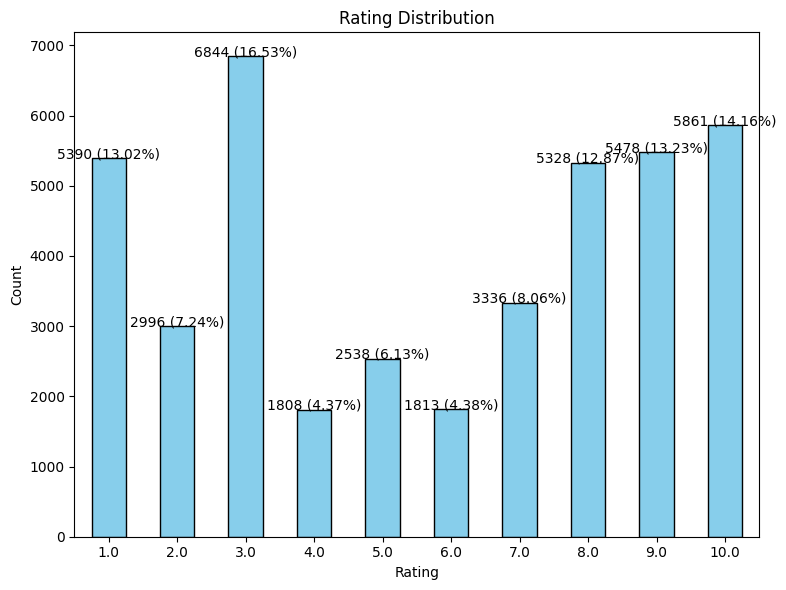

In [9]:
# Count values and calculate percentages, including NaN values
rating_counts = flight_review_df['overall_rating'].value_counts().sort_index()
total_records = len(flight_review_df)
rating_percentages = (rating_counts / total_records) * 100

# Create a table using Pandas, including NaN values
rating_table = pd.DataFrame({'Count': rating_counts, 'Percentage': rating_percentages})
rating_table.index = rating_table.index.fillna('NaN')

# Add a row for the total count and percentage
total_count = rating_counts.sum()
total_percentage = 100.0  # Total percentage is always 100%
rating_table.loc['Total'] = [total_count, total_percentage]

# Print the table
print("Rating Distribution Table:")
print(rating_table)

# Create a bar plot for visualization, including NaN values
plt.figure(figsize=(8, 6))
rating_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Display the percentage on top of the bars, including NaN values
for i, count in enumerate(rating_counts):
    label = f'{count} ({rating_percentages[rating_counts.index[i]]:.2f}%)'
    plt.text(i, count + 0.5, label, ha='center')

plt.tight_layout()
plt.show()


In [10]:
import time

# Generate a unique file name with an epoch timestamp
timestamp = int(time.time())
output_file_path = f'./Exported_DF/imputed_df_{timestamp}.csv'

# Export the DataFrame to a CSV file with the unique timestamped file name
flight_review_df.to_csv(output_file_path, index=False)

print(f'DataFrame has been exported to {output_file_path}')

DataFrame has been exported to ./Exported_DF/imputed_df_1700844753.csv


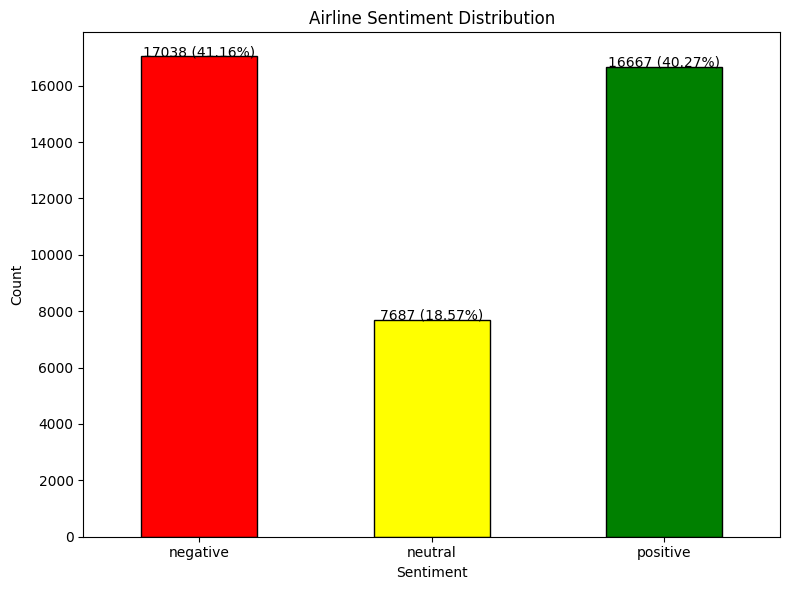

In [11]:
# Function to categorize sentiment based on 'overall_rating'
def categorize_sentiment(rating):
    if 8 <= rating <= 10:
        return 'positive'
    elif 5 <= rating <= 7:
        return 'neutral'
    elif 1 <= rating <= 4:
        return 'negative'
    else:
        return 'unknown'

# Create the 'airline_sentiment' column based on 'overall_rating'
flight_review_df['airline_sentiment'] = flight_review_df['overall_rating'].apply(categorize_sentiment)

# Count values and calculate percentages
sentiment_counts = flight_review_df['airline_sentiment'].value_counts().sort_index()
total_records = len(flight_review_df)
sentiment_percentages = (sentiment_counts / total_records) * 100

# Define colors for the sentiments
colors = {'positive': 'green', 'neutral': 'yellow', 'negative': 'red'}

# Create a bar plot with specified colors
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=[colors[sentiment] for sentiment in sentiment_counts.index], edgecolor='black')
plt.title('Airline Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Display the percentage on top of the bars
for i, count in enumerate(sentiment_counts):
    plt.text(i, count + 0.5, f'{count} ({sentiment_percentages[i]:.2f}%)', ha='center')

plt.tight_layout()
plt.show()



#### __Data Wrangling__:

Conduct data wrangling on `flight metadata` to transform and structure data into a desired format

In [12]:
# Rename the 'content' column to 'review'
flight_review_df.rename(columns={'content': 'review'}, inplace=True)

# Show DataFrame to check if 'review' column instead of 'content'
flight_review_df.head(20)

,date,review,overall_rating,recommended,airline_sentiment
0,2015-04-10,Outbound flight FRA/PRN A319. 2 hours 10 min f...,7.0,1,neutral
1,2015-01-05,Two short hops ZRH-LJU and LJU-VIE. Very fast ...,10.0,1,positive
2,2014-09-14,Flew Zurich-Ljubljana on JP365 newish CRJ900. ...,9.0,1,positive
3,2014-09-06,Adria serves this 100 min flight from Ljubljan...,8.0,1,positive
4,2014-06-16,WAW-SKJ Economy. No free snacks or drinks on t...,4.0,0,negative
5,2014-06-08,Sarajevo-Frankfurt via Ljubljana. I loved flyi...,9.0,1,positive
6,2014-06-01,I had flights from Paris to Sarajevo via Ljubl...,5.0,1,neutral
7,2014-05-10,LJU to FRA and back both flights were on time....,9.0,1,positive
8,2014-01-13,On my Ljubljana - Munich flight in business cl...,8.0,1,positive
9,2014-01-06,Flights from LJU to ZRH and back all on time. ...,10.0,1,positive


In [13]:
# Convert 'date' to datetime
flight_review_df['review_date'] = pd.to_datetime(flight_review_df['date'])

# Extract year, month into separate columns
flight_review_df['review_year'] = flight_review_df['review_date'].dt.year
flight_review_df['review_month'] = flight_review_df['review_date'].dt.month

flight_review_df.head(5)

,date,review,overall_rating,recommended,airline_sentiment,review_date,review_year,review_month
0,2015-04-10,Outbound flight FRA/PRN A319. 2 hours 10 min f...,7.0,1,neutral,2015-04-10,2015,4
1,2015-01-05,Two short hops ZRH-LJU and LJU-VIE. Very fast ...,10.0,1,positive,2015-01-05,2015,1
2,2014-09-14,Flew Zurich-Ljubljana on JP365 newish CRJ900. ...,9.0,1,positive,2014-09-14,2014,9
3,2014-09-06,Adria serves this 100 min flight from Ljubljan...,8.0,1,positive,2014-09-06,2014,9
4,2014-06-16,WAW-SKJ Economy. No free snacks or drinks on t...,4.0,0,negative,2014-06-16,2014,6


<Figure size 800x600 with 0 Axes>

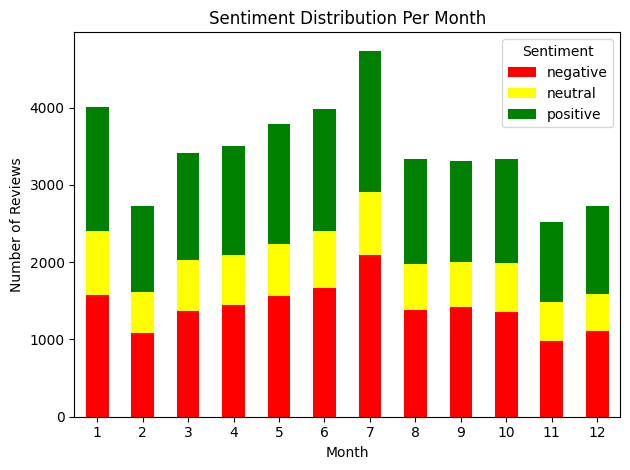

In [14]:
# Convert 'date' to datetime
flight_review_df['review_date'] = pd.to_datetime(flight_review_df['date'])

# Extract year, month into separate columns
flight_review_df['review_year'] = flight_review_df['review_date'].dt.year
flight_review_df['review_month'] = flight_review_df['review_date'].dt.month

# Create a pivot table to count sentiments per month
pivot_table = flight_review_df.pivot_table(index='review_month', columns='airline_sentiment', aggfunc='size', fill_value=0)

# Reorder columns to match the desired order: Negative, Neutral, Positive
pivot_table = pivot_table[['negative', 'neutral', 'positive']]

# Define colors for the bars
colors = ['red', 'yellow', 'green']

# Create a stacked bar plot with specified colors
plt.figure(figsize=(8, 6))
pivot_table.plot(kind='bar', stacked=True, color=colors)
plt.title('Sentiment Distribution Per Month')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.legend(title='Sentiment')

plt.tight_layout()
plt.show()


In [15]:
# Show statistical summary of flight review
flight_review_df.describe()

,overall_rating,recommended,review_year,review_month
count,41392.000000,41392.000000,41392.000000,41392.000000
mean,5.716129,0.533799,2013.059359,6.284548
std,3.179545,0.498862,1.859187,3.302498
min,1.000000,0.000000,1970.000000,1.000000
25%,3.000000,0.000000,2012.000000,4.000000
50%,6.000000,1.000000,2014.000000,6.000000
75%,9.000000,1.000000,2014.000000,9.000000
max,10.000000,1.000000,2015.000000,12.000000


#### __For Text Pre-processing__:

__The flight review undergo the following steps during the initial data pre-processing stage__
- Remove non-grammatical text like emails and URLs
- Remove "at the rate" and #
- Replace emojis with English word/s
- Handle contractions
- Handle slang words

In [16]:
# Download the emoji library data
demoji.download_codes()

# Extract emojis from all reviews
all_emojis = flight_review_df['review'].apply(lambda x : list(demoji.findall(x).keys())).sum()

# Count the frequency of each emoji
emoji_counts = Counter(all_emojis)

# Get the top 10 emojis by frequency
top_10_emojis = emoji_counts.most_common(10)

# Display the top 10 emojis and their frequencies
for emoji, count in top_10_emojis:
    print(f"Emoji: {emoji}, Count: {count}")

In [17]:
slang_word_dict = tp.get_slang_words(webscraped=True)
emoji_dict = tp.get_emojis()

def initial_text_preprocessing(text):
    try:
        # Remove non-grammatical text
        text = tp.remove_email_address(text)
        text = tp.remove_hyperlink(text)
        text = tp.replace_html_char(text)
        text = tp.remove_attherate(text)
        text = tp.remove_hashtag(text)    

        # Replace emojis in the 'review' column
        text = tp.replace_emojis_unicode(text)
        text = emoji_dict.replace_keywords(text)

        # Handle contractions
        text = contractions.fix(text)

        # Replace slang words
        text = slang_word_dict.replace_keywords(text)

    except Exception as err:
        print(f"ERROR: {err}")
        print(f"Input Text: {text}")

    return text


flight_review_df['cleaned_review'] = flight_review_df['review'].apply(initial_text_preprocessing)

# Display the comparison between the top 5 original review summaries and their cleaned versions
for i in range(5):
    print("Original Review:")
    print(flight_review_df['review'][i])
    print("\nCleaned Review Summary:")
    print(flight_review_df['cleaned_review'][i])
    print("="*100)

ERROR: [Errno 2] No such file or directory: './dictionary/slang_words_dictionary.pkl'
Original Review:
Outbound flight FRA/PRN A319. 2 hours 10 min flight. I thought drinks/snacks for sale but sandwich soft drinks were served complimentary. Inbound flights SKP/LJU/FRA CRJ900. each 1 hour 30 min flight. Skyshop menu was in a seat pocket and drinks/snacks were for sale. All flight crews were friendly. Security check at the Ljubljana airport for transit passengers was chaos however it's possible to go to a gate within 30min.

Cleaned Review Summary:
Outbound flight FRA/PRN A319. 2 hours 10 min flight. I thought drinks/snacks for sale but sandwich soft drinks were served complimentary. Inbound flights SKP/LJU/FRA CRJ900. each 1 hour 30 min flight. Skyshop menu was in a seat pocket and drinks/snacks were for sale. All flight crews were friendly. Security check at the Ljubljana airport for transit passengers was chaos however it is possible to go to a gate within 30min.
Original Review:
Two 

__Utilize regular expressions to eliminate punctuation, substitute whitespaces, and filter out stopwords from flight reviews__

In [18]:
nltk.download('stopwords')


# Initialize the English stop words list
list_of_stopwords = set(stopwords.words('english')) - set(['not'])

def supplemental_text_preprocessing(text):

    # Remove leading and trailing whitespaces
    text = text.strip()

    # Replace multiple whitespaces with a single space
    text = tp.replace_whitespace(text)

    # Remove stopwords
    text = tp.remove_stopwords(text, list_of_stopwords)

    return text

# Apply text cleaning to 'cleaned_review' column
flight_review_df['cleaned_review'] = flight_review_df['cleaned_review'].apply(supplemental_text_preprocessing)

# Display the comparison between the top 5 original review and their cleaned versions
for i in range(5):
    print("Original Review:")
    print(flight_review_df['review'][i])
    print("\nCleaned Review (Extra Whitespaces Removed, Stopwords Removed):")
    print(flight_review_df['cleaned_review'][i])
    print("="*100)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aurad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Original Review:
Outbound flight FRA/PRN A319. 2 hours 10 min flight. I thought drinks/snacks for sale but sandwich soft drinks were served complimentary. Inbound flights SKP/LJU/FRA CRJ900. each 1 hour 30 min flight. Skyshop menu was in a seat pocket and drinks/snacks were for sale. All flight crews were friendly. Security check at the Ljubljana airport for transit passengers was chaos however it's possible to go to a gate within 30min.

Cleaned Review (Extra Whitespaces Removed, Stopwords Removed):
Outbound flight hours min flight I thought sale sandwich soft drinks served complimentary Inbound flights hour min flight Skyshop menu seat pocket sale All flight crews friendly Security check Ljubljana airport transit passengers chaos however possible go gate within
Original Review:
Two short hops ZRH-LJU and LJU-VIE. Very fast on CRJ 90. Seats comfortable and crew was fine. Ground services good and lounge was quite nice.

Cleaned Review (Extra Whitespaces Removed, Stopwords Removed):
Two

Show data frequency for each sentiment

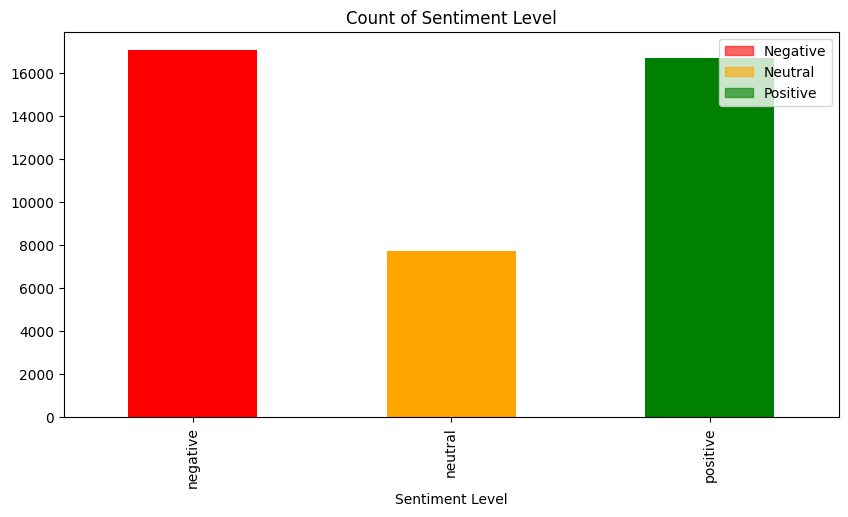

In [19]:
# Define the colors for each sentiment
sentiment_colors = {
    'negative': 'red',
    'neutral': 'orange',
    'positive': 'green'
}

# Count the reviews based on dataset Sentiment Level
sentiment_counts = flight_review_df['airline_sentiment'].value_counts().sort_index()
sentiments = sentiment_counts.index
colors = [sentiment_colors[s] for s in sentiments]

# Create the bar chart
ax = sentiment_counts.plot(kind='bar', title='Count of Sentiment Level', figsize=(10, 5), color=colors)

ax.set_xlabel('Sentiment Level')

# Add a custom legend for sentiments
legend_labels = {
    'negative': 'Negative',
    'neutral': 'Neutral',
    'positive': 'Positive'
}

legend_handles = [plt.Rectangle((0, 0), 1, 1, color=sentiment_colors[s], alpha=0.6, label=label)
                  for s, label in legend_labels.items()]

ax.legend(handles=legend_handles, loc='upper right')

plt.show()


In [20]:
# Rearrange the order of columns
desired_order = ['review', 'cleaned_review', 'airline_sentiment','overall_rating']
flight_review_df = flight_review_df[desired_order]
flight_review_df.head(5)

,review,cleaned_review,airline_sentiment,overall_rating
0,Outbound flight FRA/PRN A319. 2 hours 10 min f...,Outbound flight hours min flight I thought sal...,neutral,7.0
1,Two short hops ZRH-LJU and LJU-VIE. Very fast ...,Two short hops Very fast CRJ Seats comfortable...,positive,10.0
2,Flew Zurich-Ljubljana on JP365 newish CRJ900. ...,Flew newish Flight almost full departure time ...,positive,9.0
3,Adria serves this 100 min flight from Ljubljan...,Adria serves min flight Ljubljana Amsterdam br...,positive,8.0
4,WAW-SKJ Economy. No free snacks or drinks on t...,Economy No free snacks drinks Star Alliance pa...,negative,4.0


## Pre-trained Model Predictions and Evaluation

Execute the two pre-trained models for sentiment analysis, namely VADER and RoBERTa, then get their predictions

__1. VADER (Valence Aware Dictionary for Sentiment Reasoning)__

VADER is a pre-trained sentiment analysis model designed for analyzing the sentiment of text, particularly in the context of social media. Developed by researchers at the Georgia Institute of Technology, VADER is specifically tuned to handle the nuances of sentiment expressed in short and informal texts, such as tweets or online comments.

In [21]:
def process_vader_sentiment(df):
    # Generate sentiments using VADER
    df['vader_sentiment'] = df['cleaned_review'].apply(lambda x : md.generate_vader_labels(x))

    # Flag to check if vader sentiments match with the airline sentiments
    df['vader_is_matched'] = df['vader_sentiment'] == df['airline_sentiment']

    return df


try:  
    print("Parallel processing of flight airline reviews...")
    flight_review_df = utils.parallel_processing(flight_review_df, process_vader_sentiment)

    display(flight_review_df.head(10))
except Exception as err:
    print(f"ERROR: {err}")

Parallel processing of flight airline reviews...


__2. RoBERTa (Robustly Optimized BERT Pre-training)__

RoBERTa is a natural language processing (NLP) model developed by Facebook AI. It is an extension and optimization of the BERT (Bidirectional Encoder Representations from Transformers) model architecture. RoBERTa was introduced to address some limitations and enhance the performance of BERT.

In [ ]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)

def process_roberta_sentiment(df):
    # Generate sentiments using RoBERTa
    df['roberta_sentiment'] = df['cleaned_review'].apply(lambda x : md.generate_roberta_labels(x, model, tokenizer))

    # Flag to check if vader sentiments match with the airline sentiments
    df['roberta_is_matched'] = df['roberta_sentiment'] == df['airline_sentiment']

    return df


try:  
    print("Parallel processing of flight airline reviews...")
    flight_review_df = utils.parallel_processing(flight_review_df, process_roberta_sentiment)

    display(flight_review_df.head(10))
except Exception as err:
    print(f"ERROR: {err}")

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


Parallel processing of flight airline reviews...


#### __Feature Engineering:__

Convert airline, RoBERTa and VADER sentiment labels to numerical representation [Negative:0, Neutral:1, Positive:2]

In [ ]:
encoder = LabelEncoder()
flight_review_df['airline_sentiment_encoded'] = encoder.fit_transform(flight_review_df['airline_sentiment'])
flight_review_df['vader_sentiment_encoded'] = encoder.fit_transform(flight_review_df['vader_sentiment'])
flight_review_df['roberta_sentiment_encoded'] = encoder.fit_transform(flight_review_df['roberta_sentiment'])
flight_review_df.head(5)

#### __Model Evaluation:__

In [ ]:
airline_sentiments = flight_review_df['airline_sentiment_encoded']
roberta_predictions = flight_review_df['vader_sentiment_encoded']
vader_predictions = flight_review_df['roberta_sentiment_encoded']

__For VADER:__

Classification Report for VADER Predictions

              precision    recall  f1-score   support

           0       0.94      0.69      0.80      9116
           1       0.46      0.70      0.56      3092
           2       0.66      0.89      0.76      2353

    accuracy                           0.73     14561
   macro avg       0.69      0.76      0.70     14561
weighted avg       0.79      0.73      0.74     14561



Text(50.722222222222214, 0.5, 'Predicted Class')

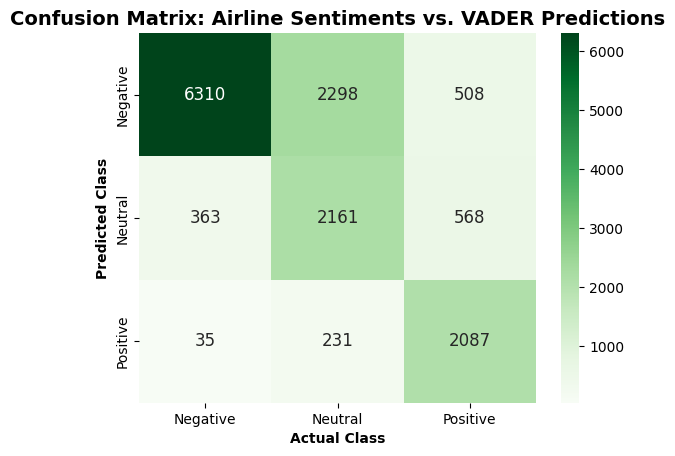

In [ ]:
print("Classification Report for VADER Predictions\n")
print(classification_report(airline_sentiments, vader_predictions))

# Create a confusion matrix
class_labels = ['Negative', 'Neutral', 'Positive']
cm = confusion_matrix(airline_sentiments, vader_predictions)
cm_matrix = pd.DataFrame(data=cm, columns=class_labels, index=class_labels)

sb.heatmap(cm_matrix, cmap='Greens', annot=True, fmt='d', annot_kws={"size": 12})

plt.title('Confusion Matrix: Airline Sentiments vs. VADER Predictions', fontsize=14, fontweight='bold')
plt.xlabel('Actual Class', fontweight='bold')
plt.ylabel('Predicted Class', fontweight='bold')

__For RoBERTa:__

Classification Report for RoBERTa Predictions

              precision    recall  f1-score   support

           0       0.90      0.40      0.56      9116
           1       0.36      0.36      0.36      3092
           2       0.29      0.90      0.43      2353

    accuracy                           0.47     14561
   macro avg       0.51      0.55      0.45     14561
weighted avg       0.69      0.47      0.50     14561



Text(50.722222222222214, 0.5, 'Predicted Class')

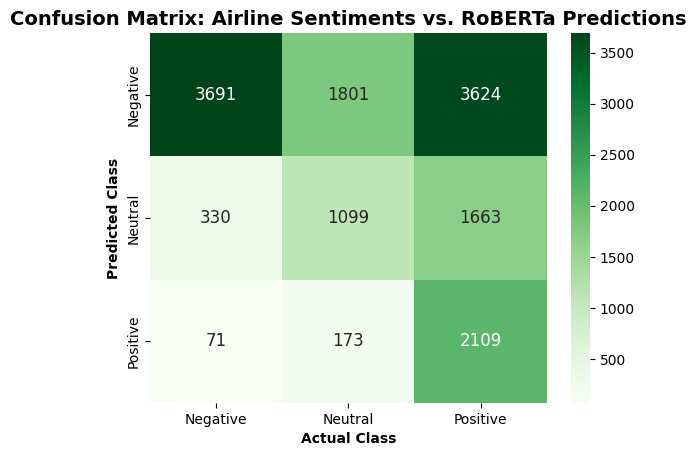

In [ ]:
print("Classification Report for RoBERTa Predictions\n")
print(classification_report(airline_sentiments, roberta_predictions))

# Create a confusion matrix
class_labels = ['Negative', 'Neutral', 'Positive']
cm = confusion_matrix(airline_sentiments, roberta_predictions)
cm_matrix = pd.DataFrame(data=cm, columns=class_labels, index=class_labels)

sb.heatmap(cm_matrix, cmap='Greens', annot=True, fmt='d', annot_kws={"size": 12})

plt.title('Confusion Matrix: Airline Sentiments vs. RoBERTa Predictions', fontsize=14, fontweight='bold')
plt.xlabel('Actual Class', fontweight='bold')
plt.ylabel('Predicted Class', fontweight='bold')

## Group Members
- Auradee Castro
- Bhumika Rajendra Babu
- Miraj Sinya
- Olivia Deguit
- Roger Mais